In [1]:
# -*- coding: utf-8 -*-
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tempfile
from pathlib import Path


from qiskit import QuantumCircuit, transpile
from qiskit.exceptions import QiskitError
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import DensityMatrix, state_fidelity
from sklearn.linear_model import Ridge
import tensorflow_probability as tfp
tfd = tfp.distributions

# ── 乱数固定 ─────────────────────────────────────────────────────────────
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ── IBM Runtime アカウント登録（初回のみ置換） ──────────────────────────
QiskitRuntimeService.save_account(
    channel='ibm_cloud',
    token='hUNKim03EUNPLFj0N2_D1GOZRyDVInRyGMDNptErzBCN',  # ←本番は環境変数で
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/a18f5d3ff3d6488282e0b608e5df82a1:f4255985-ae82-465b-9b64-fa2ef36a9e2c::',
    overwrite=True,
    set_as_default=True
)



# ── サービス & 実機ノイズモデル由来バックエンド ──────────────────────────
service      = QiskitRuntimeService()
real_backend = service.backend('ibm_brisbane')
base_noise_model = NoiseModel.from_backend(real_backend)
noise_model = base_noise_model

measurement_backend_dm   = AerSimulator(method='density_matrix', noise_model=noise_model)  # 忠実度参照
measurement_backend_sv   = AerSimulator(method='statevector')                               # ナビ用（擬似IQ）
measurement_backend_qasm = AerSimulator(method='automatic',    noise_model=noise_model)     # 可視化でcounts用

# --- 書き込み可能なキャッシュディレクトリを用意 ---
DATA_DIR = Path(os.environ.get("NGRC_DATA_DIR", Path(tempfile.gettempdir()) / "ngrc_cache"))
DATA_DIR.mkdir(parents=True, exist_ok=True)
NAV_PATH = DATA_DIR / "NAV_dataset.pkl"
print(f"[NG-RC] cache dir = {DATA_DIR}")

# ── ユーティリティ ────────────────────────────────────────────────────
def get_IQ_waveform(qc, backend):
    """statevector の Re/Im を擬似IQとして取得（ナビ用）"""
    qc2 = qc.copy()
    qc2.save_statevector()
    tqc = transpile(qc2, backend)
    result = backend.run(tqc).result()
    state = result.get_statevector(0)
    return np.real(state), np.imag(state)

def get_density_matrix(qc, backend):
    qc2 = qc.copy(); qc2.save_density_matrix()
    tqc = transpile(qc2, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.data(0)['density_matrix'])

def get_counts(qc, backend, shots=8192):
    qc2 = qc.copy(); qc2.measure_all()
    tqc = transpile(qc2, backend)
    result = backend.run(tqc, shots=shots).result()
    return result.get_counts(0)

def compute_fidelity_to_Rx_pi2(density_matrix_measured):
    # Rx(pi/2)|0> = (1/√2) [1, -i]
    psi_ideal = (1/np.sqrt(2)) * np.array([1, -1j])
    rho_ideal = DensityMatrix(psi_ideal)
    rho_measured = DensityMatrix(density_matrix_measured)
    return state_fidelity(rho_ideal, rho_measured)

def analyze_waveform_frequency(I_waveform, Q_waveform, dt_ns=0.5):
    dt_sec = dt_ns * 1e-9
    I_fft = np.fft.fft(I_waveform)
    Q_fft = np.fft.fft(Q_waveform)
    freqs_hz = np.fft.fftfreq(len(I_waveform), d=dt_sec)
    return freqs_hz/1e9, np.abs(I_fft), np.abs(Q_fft)  # GHz

def compute_angles_from_IQ(I_waveform, Q_waveform, dt=0.5):
    Omega_t = np.sqrt(I_waveform**2 + Q_waveform**2)  # 瞬時ラビ周波数
    theta = np.sum(Omega_t) * dt
    theta = np.mod(theta, 2*np.pi)
    phi = np.arctan2(np.sum(Q_waveform), np.sum(I_waveform))
    return theta, phi


# ── NG-RC（ナビ用：スコア回帰器） ───────────────────────────────────────
class NGReservoirComputer:
    """
    Non-linear Gate Reservoir Computer (ナビ用)
      window_size  : 時系列を平均化する窓幅
      poly_degree  : 非線形次数 (d ≥ 2)
      alpha        : Ridge 正則化
    """
    def __init__(self, window_size: int = 10, poly_degree: int = 3, alpha: float = 1.0):
        self.w     = window_size
        self.poly  = poly_degree
        self.model = Ridge(alpha=alpha)

    def _extract_features(self, I: np.ndarray, Q: np.ndarray) -> np.ndarray:
        # 線形 (窓平均)
        lin_feats = []
        for start in range(0, len(I), self.w):
            lin_feats.extend([
                np.mean(I[start:start+self.w]),
                np.mean(Q[start:start+self.w])
            ])
        # 非線形 (系列全体の d 乗平均)
        nl_feats = []
        for d in range(2, self.poly + 1):
            nl_feats.extend([np.mean(I**d), np.mean(Q**d)])
        return np.array(lin_feats + nl_feats)

    def fit(self, df: pd.DataFrame) -> None:
        X = np.stack([self._extract_features(r['I'], r['Q']) for _, r in df.iterrows()])
        y = df['score'].values.astype(float)
        self.model.fit(X, y)

    def predict(self, I: np.ndarray, Q: np.ndarray) -> float:
        f = self._extract_features(I, Q).reshape(1, -1)
        return float(self.model.predict(f)[0])

def make_nav_dataset(backend_iq, backend_dm, n_each=200):
    # 基本状態群
    def base_states():
        yield lambda qc: None
        yield lambda qc: qc.x(0)
        yield lambda qc: qc.rx(np.pi/2, 0)
        yield lambda qc: qc.rx(-np.pi/2, 0)
        yield lambda qc: qc.ry(np.pi/2, 0)
        yield lambda qc: qc.ry(-np.pi/2, 0)
        yield lambda qc: qc.rx(np.pi/4, 0)
        yield lambda qc: qc.ry(np.pi/4, 0)
        yield lambda qc: qc.rx(3*np.pi/4, 0)
        yield lambda qc: qc.ry(3*np.pi/4, 0)

    circuits_for_sv, circuits_for_dm = [], []
    for prep in base_states():
        for _ in range(n_each):
            qc = QuantumCircuit(1)
            prep(qc)
            delta = np.random.uniform(-0.02, 0.02)  # 微小擾乱
            qc.rz(delta, 0)

            qc_sv = qc.copy(); qc_sv.save_statevector();    circuits_for_sv.append(qc_sv)
            qc_dm = qc.copy(); qc_dm.save_density_matrix();  circuits_for_dm.append(qc_dm)

    tqc_sv = transpile(circuits_for_sv, backend_iq, optimization_level=0)
    tqc_dm = transpile(circuits_for_dm, backend_dm, optimization_level=0)

    res_sv = backend_iq.run(tqc_sv).result()
    res_dm = backend_dm.run(tqc_dm).result()

    rows = []
    for i in range(len(circuits_for_sv)):
        state = res_sv.get_statevector(i)
        I, Q = np.real(state), np.imag(state)
        rho  = np.asarray(res_dm.data(i)['density_matrix'])
        fid  = compute_fidelity_to_Rx_pi2(rho)
        rows.append({'I': np.asarray(I, float), 'Q': np.asarray(Q, float), 'score': float(fid)})
    return pd.DataFrame(rows)

# ── ナビ用データの生成／学習 ─────────────────────────────────────────────
if not NAV_PATH.exists():
    print('[NG-RC] NAV_dataset.pkl が無いので生成 …')
    nav_df = make_nav_dataset(
        backend_iq = measurement_backend_sv,   # 擬似IQ
        backend_dm = measurement_backend_dm,   # 忠実度評価はノイズ側
        n_each = 200
    )
    # 書き込み可能な場所に保存
    nav_df.to_pickle(NAV_PATH)
    print(f"[NG-RC] saved cache → {NAV_PATH}")
else:
    print(f"[NG-RC] load cache ← {NAV_PATH}")
    nav_df = pd.read_pickle(NAV_PATH)

ng_rc = NGReservoirComputer(window_size=10, poly_degree=3, alpha=1.0)
ng_rc.fit(nav_df)
print('[NG-RC] ナビ学習完了 (score=fidelity_to_Rx(pi/2))')

# ── RL エージェント ────────────────────────────────────────────────────
class MultiObjectivePolicyGradientAgent:
    def __init__(self, state_size, min_waveform_length=45, max_waveform_length=70, initial_learning_rate=0.002):
        self.state_size = state_size
        self.min_waveform_length = min_waveform_length
        self.max_waveform_length = max_waveform_length
        self.waveform_length_range = self.max_waveform_length - self.min_waveform_length + 1
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        self.best_waveform = None
        self.best_reward = -float('inf')
        self.model = self._build_model()

    def _build_model(self):
        initializer = tf.keras.initializers.GlorotUniform()
        model_input = tf.keras.layers.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(model_input)
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
        x = tf.keras.layers.Reshape((256, 1))(x)
        x = tf.keras.layers.LSTM(128, return_sequences=False)(x)

        waveform_param_size = 4 * self.max_waveform_length
        waveform_params = tf.keras.layers.Dense(waveform_param_size, activation='tanh', kernel_initializer=initializer)(x)
        waveform_length_logits_size = self.waveform_length_range
        waveform_length_logits = tf.keras.layers.Dense(waveform_length_logits_size, activation=None,
                                                       kernel_initializer=initializer, bias_initializer='zeros')(x)
        return tf.keras.Model(inputs=model_input, outputs=[waveform_params, waveform_length_logits])

    def generate_waveform(self, state):
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        waveform_params, waveform_length_logits = self.model(state_tensor)
        waveform_params = waveform_params[0]; waveform_length_logits = waveform_length_logits[0]

        max_amplitude = 0.13
        L_dist = tfd.Categorical(logits=waveform_length_logits)
        L_idx  = L_dist.sample()
        L      = self.min_waveform_length + L_idx
        L      = tf.cast(L, tf.int32)
        L_val  = int(L.numpy())

        I_mean = max_amplitude * waveform_params[:self.max_waveform_length]
        I_std  = max_amplitude * (tf.nn.softplus(waveform_params[self.max_waveform_length:2*self.max_waveform_length]) + 1e-3)
        Q_mean = max_amplitude * waveform_params[2*self.max_waveform_length:3*self.max_waveform_length]
        Q_std  = max_amplitude * (tf.nn.softplus(waveform_params[3*self.max_waveform_length:4*self.max_waveform_length]) + 1e-3)

        I_full = tf.clip_by_value(I_mean + I_std*tf.random.normal(I_mean.shape), -max_amplitude, max_amplitude)
        Q_full = tf.clip_by_value(Q_mean + Q_std*tf.random.normal(Q_mean.shape), -max_amplitude, max_amplitude)
        I = I_full[:L_val]; Q = Q_full[:L_val]
        return I.numpy(), Q.numpy(), L_val

    def compute_discounted_rewards(self, rewards, gamma=0.98):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0.0
        for t in reversed(range(len(rewards))):
            cumulative = rewards[t] + gamma * cumulative
            discounted_rewards[t] = cumulative
        return discounted_rewards

    def update_policy(self, states, rewards, actions, gamma=0.98):
        discounted = self.compute_discounted_rewards(rewards, gamma).astype(np.float32)
        if len(discounted) > 1:
            discounted = (discounted - discounted.mean()) / (discounted.std() + 1e-8)
        discounted = tf.convert_to_tensor(discounted, dtype=tf.float32)

        with tf.GradientTape() as tape:
            state_tensors = tf.convert_to_tensor(states, dtype=tf.float32)
            wf_params_batch, wf_len_logits_batch = self.model(state_tensors)

            log_probs = []
            maxL = self.max_waveform_length
            for i, act in enumerate(actions):
                L_val = int(act['L'])
                I_samp = tf.convert_to_tensor(act['I'][:L_val], dtype=tf.float32)
                Q_samp = tf.convert_to_tensor(act['Q'][:L_val], dtype=tf.float32)

                params = wf_params_batch[i]
                len_logits = wf_len_logits_batch[i]
                L_dist = tfd.Categorical(logits=len_logits)
                L_idx  = tf.cast(L_val - self.min_waveform_length, tf.int32)
                logp_L = L_dist.log_prob(L_idx)

                I_mean = 0.13 * params[:maxL]
                I_std  = 0.13 * (tf.nn.softplus(params[maxL:2*maxL]) + 1e-3)
                Q_mean = 0.13 * params[2*maxL:3*maxL]
                Q_std  = 0.13 * (tf.nn.softplus(params[3*maxL:4*maxL]) + 1e-3)

                I_dist = tfd.Normal(I_mean[:L_val], I_std[:L_val])
                Q_dist = tfd.Normal(Q_mean[:L_val], Q_std[:L_val])

                logp_I = tf.reduce_sum(I_dist.log_prob(I_samp))
                logp_Q = tf.reduce_sum(Q_dist.log_prob(Q_samp))
                log_probs.append(logp_I + logp_Q + logp_L)

            log_probs = tf.stack(log_probs)
            loss = -tf.reduce_mean(discounted * log_probs)

        grads = tape.gradient(loss, self.model.trainable_variables)
        grads_and_vars = [(g, v) for g, v in zip(grads, self.model.trainable_variables) if g is not None]
        if not grads_and_vars:
            return
        grads_and_vars = [(tf.clip_by_value(g, -5.0, 5.0), v) for g, v in grads_and_vars]
        self.optimizer.apply_gradients(grads_and_vars)

# ── 最適化ループ ───────────────────────────────────────────────────────
def design_and_optimize_pulse(agent, backend_dm, backend_sv,
                              ngrc_model=None, use_nav=False,
                              cycles=2500, batch_size=32, log_rows=None):

    total_batches = int(math.ceil(cycles / batch_size))
    global_batch = 0

    # 重みは固定：α=0.90（忠実度）β=0.05（ナビ）γ=0.05（長さ）
    def weight_schedule(*args, **kwargs):
        return 0.9, 0.05, 0.05

    if log_rows is None:
        log_rows = []

    all_rewards = []
    batch_states, batch_rewards = [], []
    current_batch_actions = []

    fidelity_list, total_reward_list = [], []
    waveform_length_list, theta_list, phi_list = [], [], []

    for cycle in range(cycles):
        if (cycle % 10) == 0:
            print(f"Cycle {cycle + 1}/{cycles}")

        qc = QuantumCircuit(1, name='state_experiment')
        try:
            density_matrix = get_density_matrix(qc, backend_dm)
        except QiskitError as e:
            print(f"Cycle {cycle + 1}: {e}")
            continue

        state_vector = np.concatenate([np.real(density_matrix).flatten(),
                                       np.imag(density_matrix).flatten()])
        batch_states.append(state_vector)
        batch_rewards.append(0.0)

        if (cycle + 1) % batch_size == 0:
            current_batch_states = batch_states.copy()
            current_batch_rewards = []
            current_batch_actions = []

            batch_fidelity, batch_total_reward = [], []
            batch_waveform_length, batch_theta, batch_phi = [], [], []

            for state in current_batch_states:
                I_waveform, Q_waveform, waveform_length = agent.generate_waveform(state)

                theta, phi = compute_angles_from_IQ(I_waveform, Q_waveform)
                qc_eval = QuantumCircuit(1, 1)
                qc_eval.ry(theta, 0); qc_eval.rx(phi, 0)

                current_batch_actions.append({'L': waveform_length, 'I': I_waveform, 'Q': Q_waveform})

                density_matrix_measured = get_density_matrix(qc_eval, backend_dm)
                fidelity_raw = compute_fidelity_to_Rx_pi2(density_matrix_measured)
                fidelity_used = fidelity_raw  # 補正は全削除


                if use_nav:
                        if ngrc_model is None:
                           raise ValueError("use_nav=True ですが ngrc_model が渡されていません。")
                        I_nav, Q_nav = get_IQ_waveform(qc_eval, backend_sv)
                        ng_score = float(np.clip(ngrc_model.predict(I_nav, Q_nav), 0.0, 1.0))
                else:
                    ng_score = 0.0

                len_penalty = (waveform_length - agent.min_waveform_length) / \
                              (agent.max_waveform_length - agent.min_waveform_length)

                alpha, beta, gamma = weight_schedule()
                total_reward = alpha * fidelity_used + beta * ng_score - gamma * len_penalty

                log_rows.append({
                    'cycle': cycle, 'batch_id': cycle // batch_size,
                    'fidelity_raw': float(fidelity_raw),
                    'fidelity_used': float(fidelity_used),
                    'ng_score': float(ng_score),
                    'len_penalty': float(len_penalty),
                    'reward': float(total_reward),
                    'wave_len': int(waveform_length),
                    'theta': float(theta), 'phi': float(phi),
                    'alpha': float(alpha), 'beta': float(beta), 'gamma': float(gamma),
                    'run_tag': 'nav' if use_nav else 'rl_only'
                })

                all_rewards.append(total_reward)
                current_batch_rewards.append(total_reward)

                if total_reward > agent.best_reward:
                    agent.best_reward = total_reward
                    agent.best_waveform = {
                        'I_waveform': I_waveform,
                        'Q_waveform': Q_waveform,
                        'theta': theta, 'phi': phi,
                        'reward': total_reward
                    }
                    print(f"    Best waveform updated with reward: {agent.best_reward:.4f}")

                batch_fidelity.append(fidelity_used)
                batch_total_reward.append(total_reward)
                batch_waveform_length.append(waveform_length)
                batch_theta.append(theta); batch_phi.append(phi)

            fidelity_list.extend(batch_fidelity)
            total_reward_list.extend(batch_total_reward)
            waveform_length_list.extend(batch_waveform_length)
            theta_list.extend(batch_theta); phi_list.extend(batch_phi)

            agent.update_policy(
                states=current_batch_states,
                rewards=current_batch_rewards,
                actions=current_batch_actions
            )
            global_batch += 1
            batch_states, batch_rewards = [], []

    return (all_rewards, fidelity_list, total_reward_list,
            waveform_length_list, theta_list, phi_list)

# ── 可視化 ──────────────────────────────────────────────────────────────
def visualize_results(agent, results):
    (all_rewards, fidelity_list, total_reward_list, waveform_length_list, theta_list, phi_list) = results
    batch_size = 32
    num_batches = len(total_reward_list) // batch_size

    mean_fidelity_list, median_fidelity_list = [], []
    mean_total_reward_list, median_total_reward_list = [], []
    mean_waveform_length_reward_list, median_waveform_length_reward_list = [], []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        mean_fidelity = np.mean(fidelity_list[start_idx:end_idx])
        mean_total_reward = np.mean(total_reward_list[start_idx:end_idx])
        median_fidelity = np.median(fidelity_list[start_idx:end_idx])
        median_total_reward = np.median(total_reward_list[start_idx:end_idx])

        waveform_length_rewards = [1 - wl / agent.max_waveform_length for wl in waveform_length_list[start_idx:end_idx]]
        mean_waveform_length_reward = np.mean(waveform_length_rewards)
        median_waveform_length_reward = np.median(waveform_length_rewards)

        mean_fidelity_list.append(mean_fidelity)
        median_fidelity_list.append(median_fidelity)
        mean_total_reward_list.append(mean_total_reward)
        median_total_reward_list.append(median_total_reward)
        mean_waveform_length_reward_list.append(mean_waveform_length_reward)
        median_waveform_length_reward_list.append(median_waveform_length_reward)

    cycles = np.arange(num_batches) * batch_size

    # 平均報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, mean_fidelity_list, 'o-', color="blue", label="Fidelity Reward (Mean)")
    plt.plot(cycles, mean_total_reward_list, 'v-', color="red", label="Total Reward (Mean)")
    plt.plot(cycles, mean_waveform_length_reward_list, 's-', color="green", label="Waveform Length Reward (Mean)")
    plt.xlabel("Cycle"); plt.ylabel("Mean Reward"); plt.title("Mean Reward Progression Over Cycles")
    plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1); plt.show()

    # 中央値報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, median_fidelity_list, 'o--', color="blue", label="Fidelity Reward (Median)")
    plt.plot(cycles, median_total_reward_list, 'v--', color="red", label="Total Reward (Median)")
    plt.plot(cycles, median_waveform_length_reward_list, 's--', color="green", label="Waveform Length Reward (Median)")
    plt.xlabel("Cycle"); plt.ylabel("Median Reward"); plt.title("Median Reward Progression Over Cycles")
    plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1); plt.show()

    if agent.best_waveform is not None:
        optimized_waveform_I = agent.best_waveform['I_waveform']
        optimized_waveform_Q = agent.best_waveform['Q_waveform']
        theta_opt = agent.best_waveform['theta']
        phi_opt = agent.best_waveform['phi']
        print(f"Optimized angles: theta = {theta_opt:.4f}, phi = {phi_opt:.4f}")

        qc_opt = QuantumCircuit(1)
        qc_opt.ry(theta_opt, 0); qc_opt.rx(phi_opt, 0)
        density_matrix_opt = get_density_matrix(qc_opt, measurement_backend_dm)
        fidelity_opt = compute_fidelity_to_Rx_pi2(density_matrix_opt)
        print("Optimized fidelity to Rx(pi/2)|0>:", fidelity_opt)

        waveform_length_opt = len(optimized_waveform_I)
        time_ns = np.arange(waveform_length_opt) * 0.5

        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red',  alpha=0.5, label='I component')
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.5, label='Q component')
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse IQ Decomposition')
        plt.xticks([]); plt.yticks([]); plt.legend(loc='upper right'); plt.grid(True); plt.show()

        # I / Q 個別
        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red', alpha=0.7)
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse: I Component')
        plt.xticks([]); plt.yticks([]); plt.grid(True); plt.show()

        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.7)
        plt.xlabel('Time (ns)'); plt.ylabel('Amplitude'); plt.title('Optimized Pulse: Q Component')
        plt.xticks([]); plt.yticks([]); plt.grid(True); plt.show()

        # 実信号合成（例: LO 5GHz）
        f_LO = 5.0e9
        omega_LO = 2 * np.pi * f_LO
        dt_sec = 0.5e-9
        I_waveform = agent.best_waveform['I_waveform']
        Q_waveform = agent.best_waveform['Q_waveform']
        t_array = np.arange(len(I_waveform)) * dt_sec
        microwave_signal = I_waveform * np.cos(omega_LO * t_array) - Q_waveform * np.sin(omega_LO * t_array)

        plt.figure(figsize=(10,4))
        plt.plot(t_array*1e9, microwave_signal, color='purple', label='Microwave Pulse (I/Q combined)')
        plt.xlabel("Time (ns)"); plt.ylabel("Amplitude (arb.)"); plt.title("Optimized Microwave Pulse (Real Signal)")
        plt.grid(True); plt.legend(); plt.show()

        # 長さ分布
        waveform_length_ns = [length * 0.5 for length in waveform_length_list]
        bin_edges = np.arange(22, 35.5, 0.5)
        plt.figure(figsize=(12,6))
        plt.hist(waveform_length_ns, bins=bin_edges, align='left', color='blue', alpha=0.7, rwidth=0.9)
        plt.title("Waveform Length Distribution (in ns)"); plt.xlabel("Waveform Length (ns)"); plt.ylabel("Frequency")
        plt.grid(True); plt.xlim(22, 35.5); plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0)); plt.show()

        # 角度分布
        plt.hist(theta_list, bins=10, color='green',  alpha=0.7, label='theta')
        plt.hist(phi_list,   bins=10, color='orange', alpha=0.7, label='phi')
        plt.title("Theta & Phi Distribution"); plt.xlabel("Angle (radians)"); plt.ylabel("Frequency")
        plt.grid(); plt.legend(); plt.show()

        # FFT
        freqs, I_fft_abs, Q_fft_abs = analyze_waveform_frequency(optimized_waveform_I, optimized_waveform_Q)
        plt.figure(figsize=(10, 5))
        plt.plot(freqs, I_fft_abs, label="I component FFT", color="red")
        plt.plot(freqs, Q_fft_abs, label="Q component FFT", color="blue")
        plt.xlabel("Frequency (GHz)"); plt.ylabel("Amplitude"); plt.title("Frequency Analysis of Optimized Waveform")
        plt.legend(); plt.grid(True); plt.show()

        # 測定結果（参考）
        counts_opt = get_counts(qc_opt, measurement_backend_qasm, shots=8192)
        states_opt = ['0', '1']; counts_plot_opt = [counts_opt.get('0', 0), counts_opt.get('1', 0)]
        plt.figure(figsize=(8,6))
        bars_opt = plt.bar(states_opt, counts_plot_opt, color='orange')
        plt.xlabel('State'); plt.ylabel('Counts'); plt.title('Measurement Results with Optimized Pulse')
        for bar in bars_opt:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
        plt.show()
    else:
        print("No optimized waveform available to visualize.")

    # 非最適化（IBM標準）比較
    qc_no_opt = QuantumCircuit(1)
    qc_no_opt.rx(np.pi/2, 0)
    density_matrix_no_opt = get_density_matrix(qc_no_opt, measurement_backend_dm)
    fidelity_no_opt = compute_fidelity_to_Rx_pi2(density_matrix_no_opt)
    waveform_length_no_opt = 36

    counts_no_opt = get_counts(qc_no_opt, measurement_backend_qasm, shots=8192)
    states_no_opt = ['0', '1']; counts_plot_no_opt = [counts_no_opt.get('0', 0), counts_no_opt.get('1', 0)]

    plt.figure(figsize=(8, 6))
    bars_no_opt = plt.bar(states_no_opt, counts_plot_no_opt, color='lightgreen')
    plt.xlabel('State'); plt.ylabel('Counts'); plt.title('Measurement Results without Optimization')
    for bar in bars_no_opt:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
    plt.show()

    if agent.best_waveform is not None:
        optimized_values = [fidelity_opt, len(agent.best_waveform['I_waveform'])*0.5]
    else:
        optimized_values = [0, 0]
    non_optimized_values = [fidelity_no_opt, waveform_length_no_opt]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    def autolabel(rects, ax, fmt='{:.4f}'):
        for rect in rects:
            h = rect.get_height()
            label = fmt.format(h) if isinstance(h, float) else str(h)
            ax.text(rect.get_x() + rect.get_width()/2., h + 0.001, label, ha='center', va='bottom', fontsize=10)

    bars_fid = axs[0].bar(['Optimized Pulse', 'IBM Pulse'],
                          [optimized_values[0], non_optimized_values[0]],
                          color=['skyblue', 'salmon'], alpha=0.8)
    axs[0].set_title('Fidelity'); axs[0].set_ylabel('Value'); axs[0].set_ylim(0.00, 1.05); autolabel(bars_fid, axs[0])

    bars_len = axs[1].bar(['Optimized Pulse', 'IBM Pulse'],
                          [optimized_values[1], non_optimized_values[1]],
                          color=['skyblue', 'salmon'], alpha=0.8)
    axs[1].set_title('Waveform Length'); axs[1].set_ylabel('Length (ns)')
    axs[1].set_ylim(0, max(optimized_values[1], non_optimized_values[1]) * 1.1); autolabel(bars_len, axs[1], fmt='{:.0f}')
    plt.tight_layout(); plt.show()


# ── 実行 ────────────────────────────────────────────────────────────────
state_size = 8
agent = MultiObjectivePolicyGradientAgent(
    state_size=state_size, min_waveform_length=45, max_waveform_length=70,
    initial_learning_rate=0.001
)



[NG-RC] cache dir = /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache
[NG-RC] load cache ← /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache/NAV_dataset.pkl
[NG-RC] ナビ学習完了 (score=fidelity_to_Rx(pi/2))


Cycle 1/2500
Cycle 11/2500
Cycle 21/2500
Cycle 31/2500
    Best waveform updated with reward: 0.0406
    Best waveform updated with reward: 0.6882
    Best waveform updated with reward: 0.6944
    Best waveform updated with reward: 0.7931
    Best waveform updated with reward: 0.7989
Cycle 41/2500
Cycle 51/2500
Cycle 61/2500
    Best waveform updated with reward: 0.8218
    Best waveform updated with reward: 0.8532
Cycle 71/2500
Cycle 81/2500
Cycle 91/2500
    Best waveform updated with reward: 0.8656
Cycle 101/2500
Cycle 111/2500
Cycle 121/2500
Cycle 131/2500
Cycle 141/2500
Cycle 151/2500
Cycle 161/2500
Cycle 171/2500
Cycle 181/2500
Cycle 191/2500
Cycle 201/2500
Cycle 211/2500
Cycle 221/2500
Cycle 231/2500
Cycle 241/2500
Cycle 251/2500
Cycle 261/2500
Cycle 271/2500
Cycle 281/2500
Cycle 291/2500
Cycle 301/2500
Cycle 311/2500
Cycle 321/2500
Cycle 331/2500
Cycle 341/2500
Cycle 351/2500
    Best waveform updated with reward: 0.8668
Cycle 361/2500
Cycle 371/2500
Cycle 381/2500
Cycle 391/25

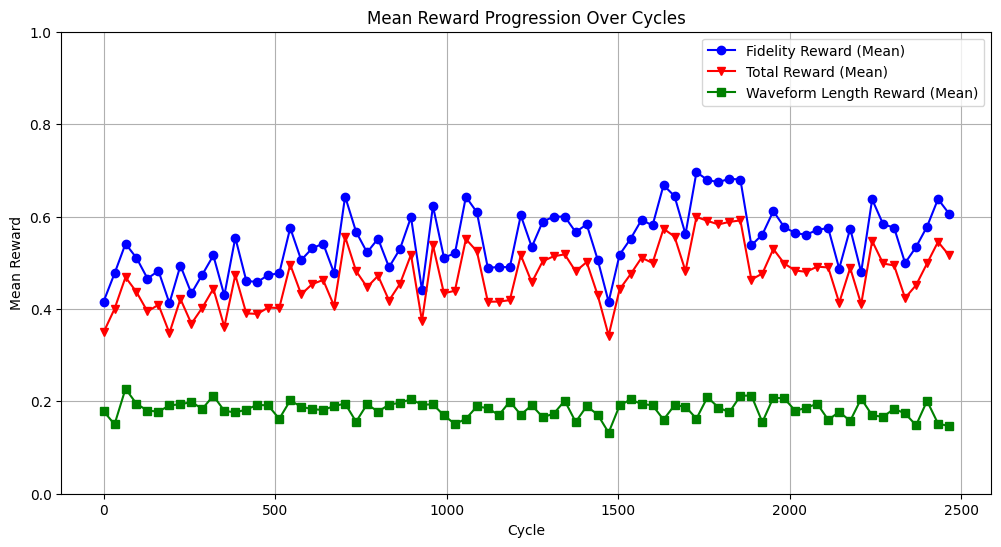

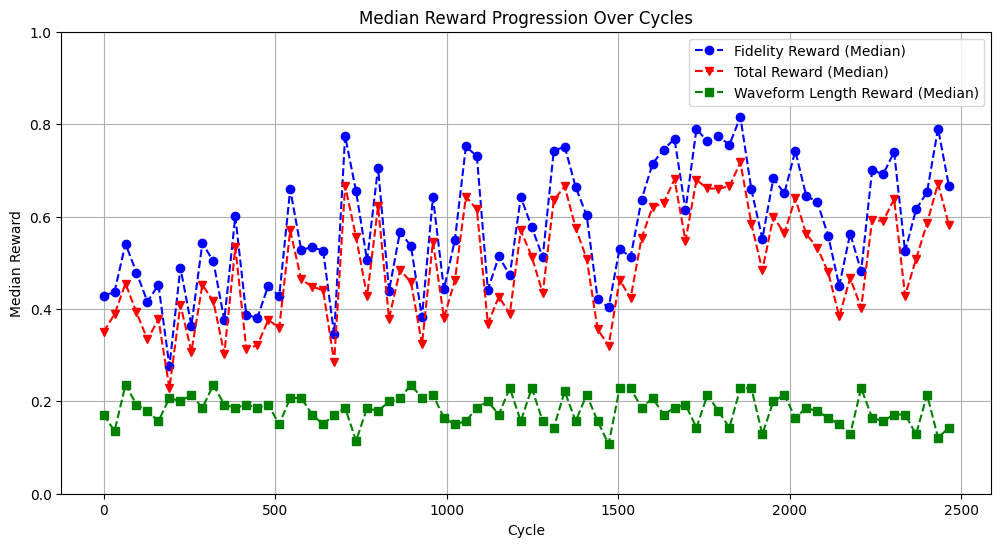

Optimized angles: theta = 3.1502, phi = -1.6193
Optimized fidelity to Rx(pi/2)|0>: 0.9983409220499673


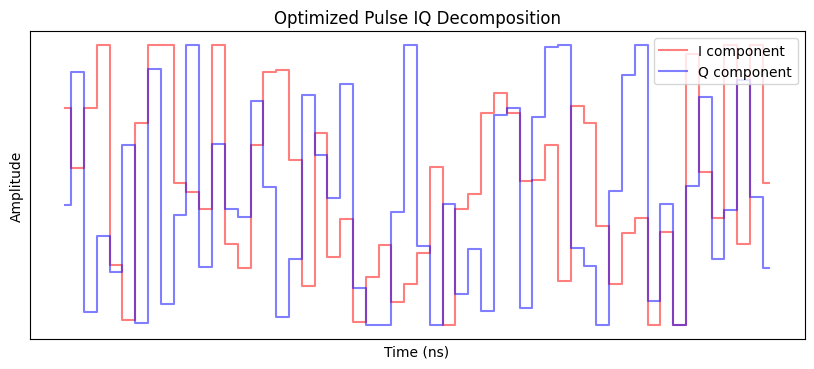

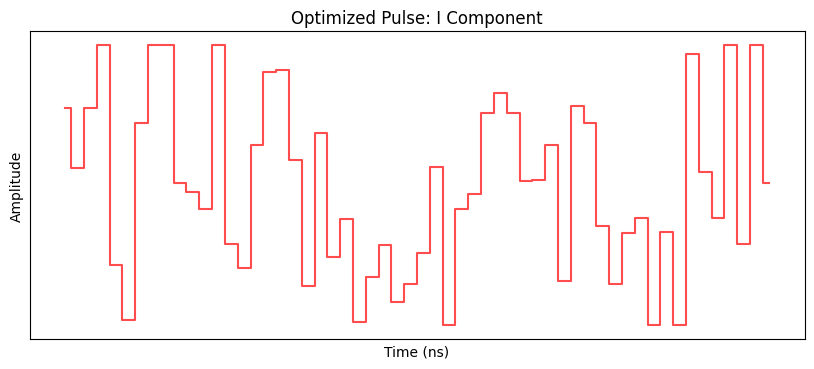

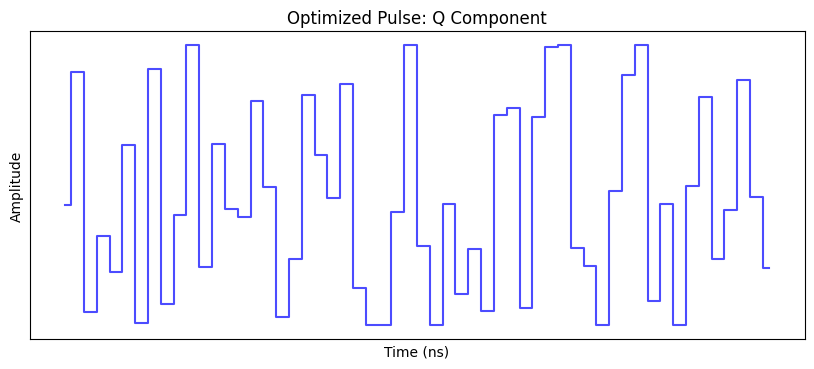

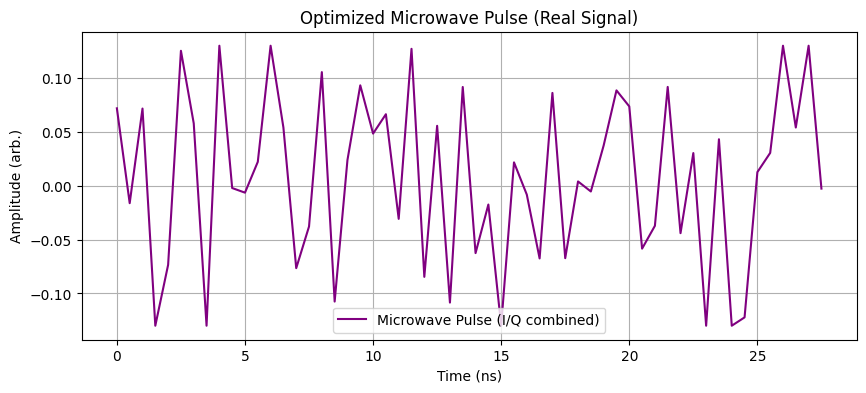

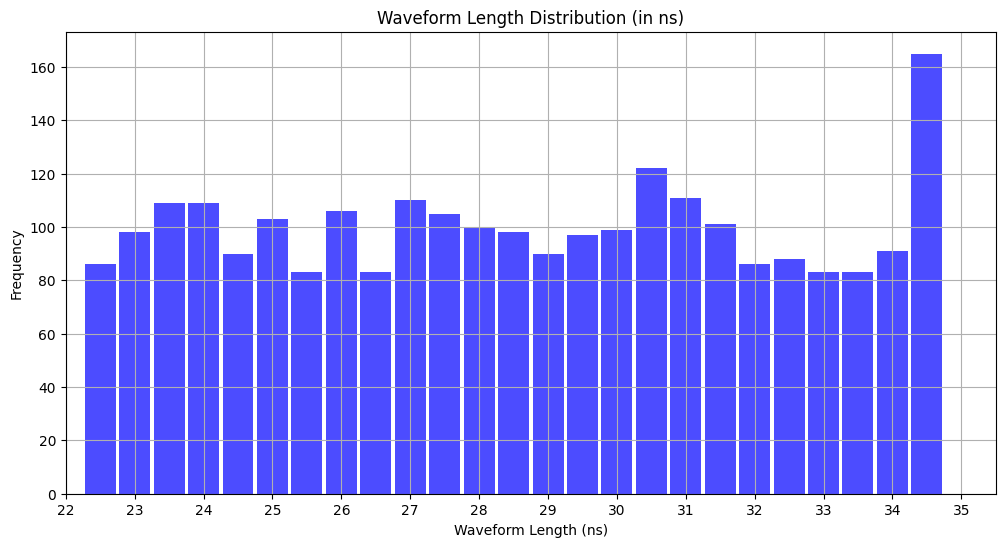

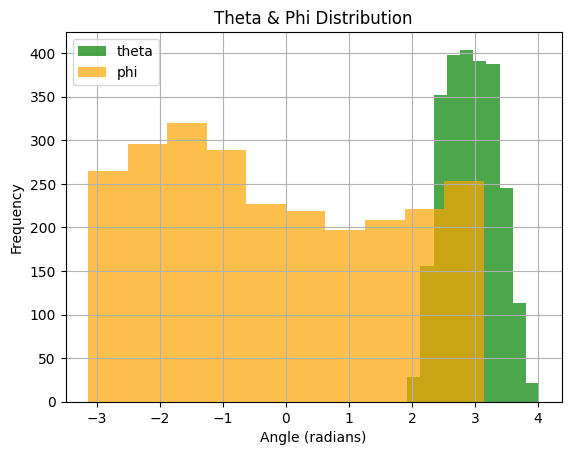

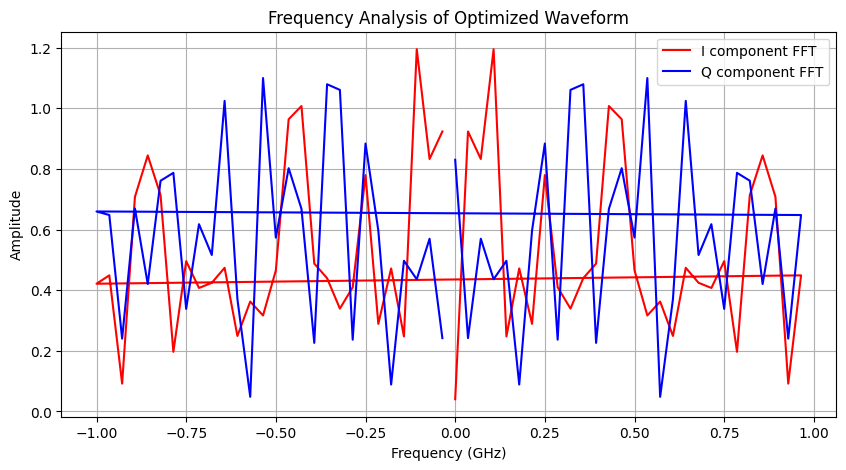

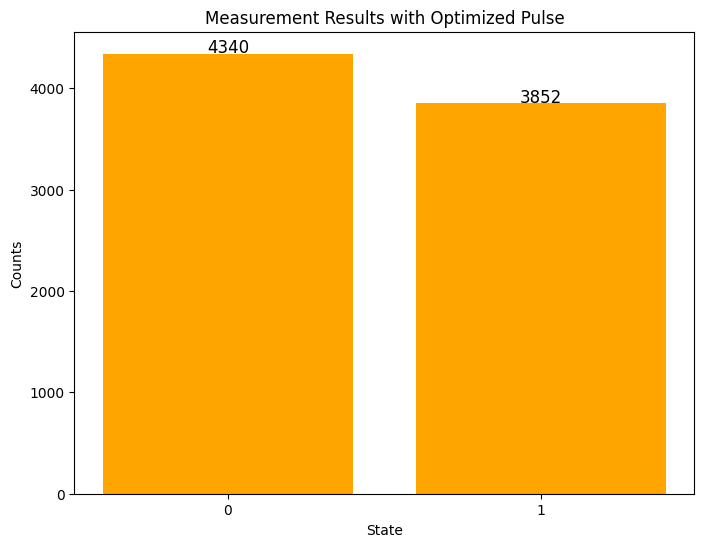

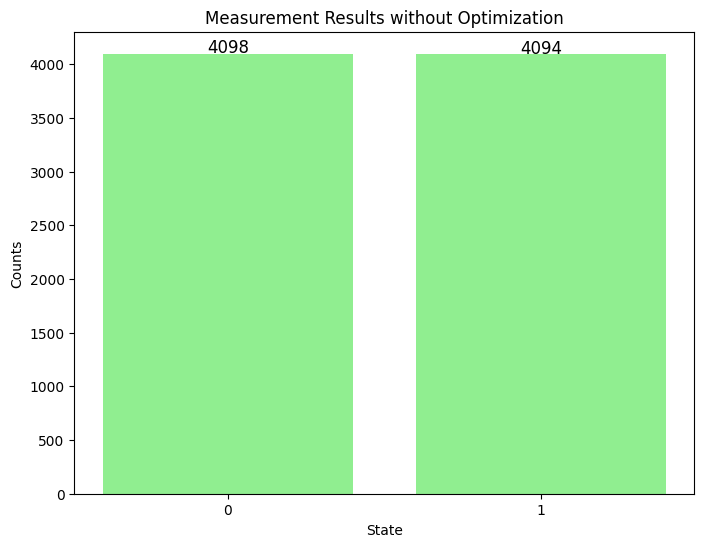

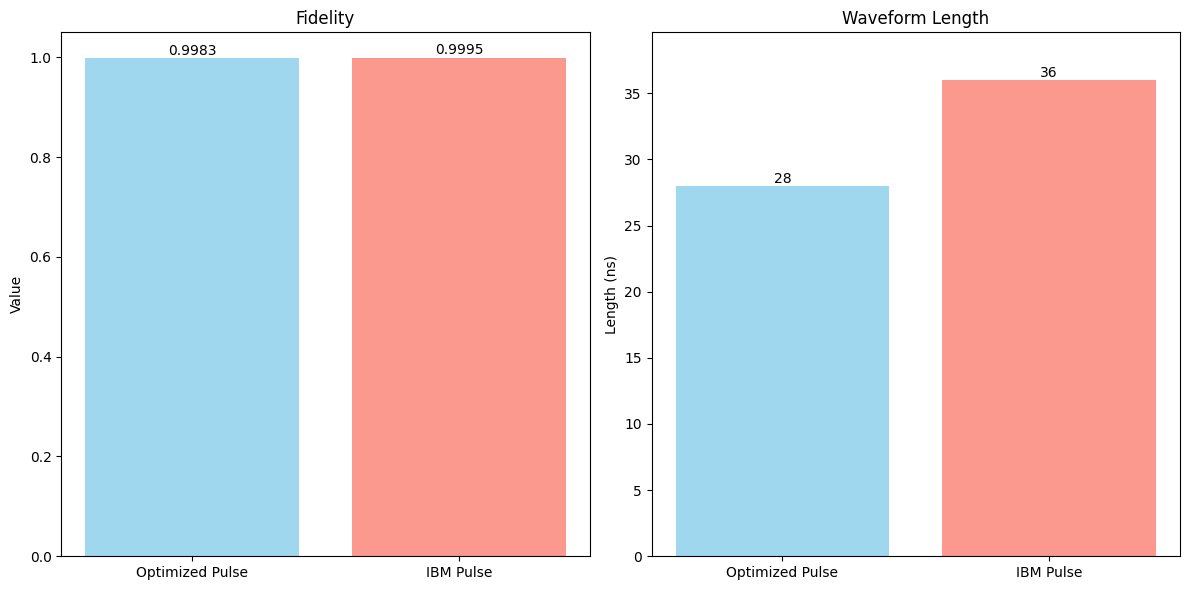

[LOG] saved → /var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ngrc_cache/run_rl_only.csv


In [2]:
# rl_onlyのみ
for tag in ['rl_only']:
    RUN_TAG = tag
    use_nav  = False

    # 条件ごとにエージェント再生成（独立性確保）
    agent = MultiObjectivePolicyGradientAgent(
        state_size=8, min_waveform_length=45, max_waveform_length=70,
        initial_learning_rate=0.001
    )

    log_rows = []
    results = design_and_optimize_pulse(
        agent,
        backend_dm=measurement_backend_dm,
        backend_sv=measurement_backend_sv,
        ngrc_model=ng_rc,
        use_nav=use_nav,
        cycles=2500, batch_size=32,
        log_rows=log_rows
    )
    visualize_results(agent, results)
    LOG_PATH = DATA_DIR / f'run_{RUN_TAG}.csv'
    pd.DataFrame(log_rows).to_csv(LOG_PATH, index=False)
    print(f'[LOG] saved → {LOG_PATH}')
